<a href="https://colab.research.google.com/github/TomPhanAnh/Kaggle-Solution/blob/main/EDA_of_bookings_and_ML_to_predict_cancelations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hotel booking**
## **Content:**
### **1. EDA**
The dataset contains data from two different hotels. One Resort hotel and one City hotel.

From the publication (https://www.sciencedirect.com/science/article/pii/S2352340918315191) we know that both hotels are located in Portugal (southern Europe) ("H1 at the resort region of Algarve and H2 at the city of Lisbon"). The distance between these two locations is ca. 280 km by car and both locations border on the north atlantic.

The data contains "bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017".

***Note:*** For most questions I will only use bookings that were not canceled, to get acutal guest numbers. As you will see, this is quite a big difference.

***Topics covered and questions to answer from the data:***

1. Where do the guests come from?
2. How much do guests pay for a room per night?
3. How does the price per night vary over the year?
4. Which are the most busy month?
5. How long do people stay at the hotels?
6. Bookings by market segment
7. How many bookings were canceled?
8. Which month have the highest number of cancelations?
9. Do you have more questions?

 Tell me in the comments and I will see if I can answer them. :)

### **2. Predicting cancelations**

It would be nice for the hotels to have a model to predict if a guest will actually come.

This can help a hotel to plan things like personel and food requirements.
Maybe some hotels also use such a model to offer more rooms than they have to make more money... who knows...

### **3. Evaluate Feature importance**
Which features are most important to predict cancelations?

Setup, data inspection and cleanup are hidden for easier reading. Click the Code/Output buttons if you are curious.

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 45.5 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=3dc1d3cee96767f0c76559245a076eba18bf20037e7e5b40f9228898f0440087
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
# Import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

# For machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 #Feature importance evaluation

# Set some display option
sns.set(style = "whitegrid")
pd.set_option("display.max_columns",36)

# load dataset
df = pd.read_csv("/content/hotel_bookings.csv")

In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [ ]:
# Replace missing values 
# agent: if no agency is given, booking was most likely made without one

# Company: if none given, it was most likely private.
# rest should be self-explanatory

nan_replacements = {"children":0,
                    "country":"Unknown",
                    "agent":0,
                    "company":0}

full_data_cln = df.fillna(nan_replacements)
# "Meal contains values "Underfined", which is equal to SC.
full_data_cln["meal"].replace("Undefined","SC", inplace = True)

# Some rows contain entries with 0 adults, 0 children and 0 babies
# I'm dropping these entries with no guests
zero_guests = list(full_data_cln.loc[full_data_cln["adults"] + full_data_cln["children"] + 
                                     full_data_cln["babies"] == 0].index)

full_data_cln.drop(full_data_cln.index[zero_guests], inplace = True)


# **Explanatory Data Analysis**

In [ ]:
# After cleaning, seperate Resort and City hotel
# To know the acutual visitor numbers, only bookings that were not canceled are included.

rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

### **Where guest come from?**

This pie chart, barh tend to show where Guest (distribute) comes from

In [ ]:
# Get the number of actual guests by countries
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"] == 0]["country"].value_counts())
country_data.rename(columns = {"country":"Number of Guests"}, inplace = True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests*100,2)
country_data["country"] = country_data.index

# Country_data.loc[country_data["Guests in %"] < 2, "country"] == "Other"

In [ ]:
# pie plot
fig = px.pie(country_data, 
             values = "Number of Guests",
             names  = "country",
             title  = "Home country of guests",
             template = "seaborn")
fig.update_traces(textposition = "inside", textinfo = "value + percent + label")
fig.show()

In [ ]:
# Show on map
guest_map = px.choropleth(country_data,
                          locations = country_data.index,
                          color = country_data["Guests in %"],
                          hover_name = country_data.index,
                          color_continuous_scale = px.colors.sequential.Plasma,
                          title = "Home country of Guests")
guest_map.show()

People from all over the world are staying in these two hotels. Most guests are from Portugal and other countries in Europe.

### **How much do guests pay for a room per night?**
Both hotels have different room types and different meal arrangements. Seasonal factors are also important. So the prices vary a lot.

Since no currency information is given, but Portugal is part of the European Monetary Union, I assume that all prices are in EUR.

In [ ]:
# Counting adults and children as paying guests only, not babies.
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print("""From all non-canceled bookings, across all  room types and meals, the average price are:
Resort hotel" {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format(rh["adr_pp"].mean(), ch["adr_pp"].mean()))

From all non-canceled bookings, across all  room types and meals, the average price are:
Resort hotel" 47.49 € per night and person.
City hotel: 59.27 € per night and person.


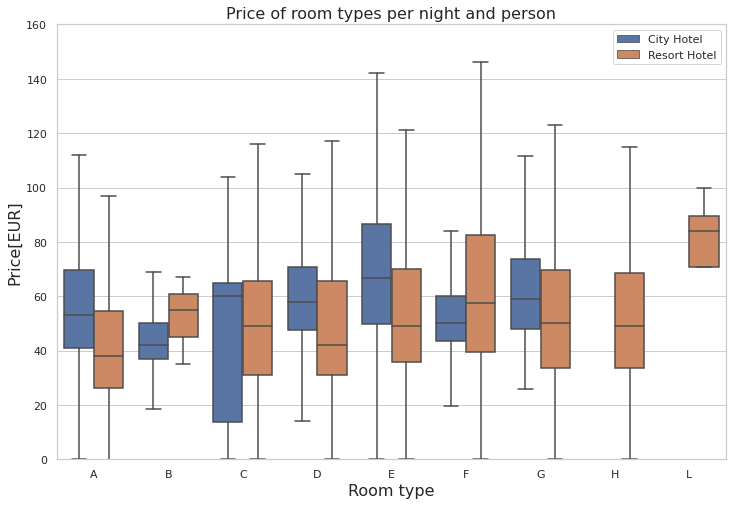

In [ ]:
# Normalize price per night (adr):
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])
full_data_guests = full_data_cln[full_data_cln["is_canceled"] == 0]
room_prices = full_data_guests[["hotel","reserved_room_type","adr_pp"]].sort_values("reserved_room_type")

# Boxplot: 
plt.figure(figsize = (12,8))
sns.boxplot(x = "reserved_room_type",
            y = "adr_pp",
            hue = "hotel",
            data = room_prices,
            hue_order = ["City Hotel","Resort Hotel"],
            fliersize = 0)
plt.title("Price of room types per night and person", fontsize = 16)
plt.xlabel("Room type", fontsize = 16)
plt.ylabel("Price[EUR]", fontsize = 16)
plt.legend(loc = "upper right")
plt.ylim(0,160)
plt.show()

This figure shows the ***average price per room, depending on its type and the standard deviation.***

Note that due to data anonymization rooms with the same type letter may not necessarily be the same across hotels.

### **How does the price per night vary over the year?¶**

To keep it simple, I'm using the average price per night and person, regardless of the room type and meal

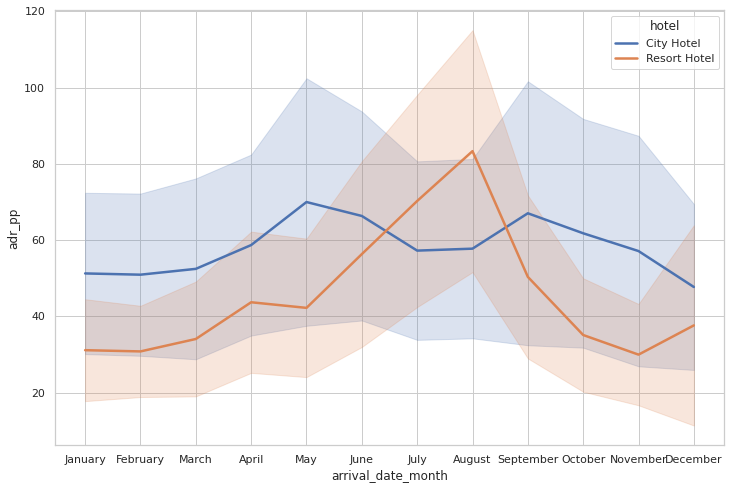

In [ ]:
# Grab data:
room_prices_monthly = full_data_guests[["hotel","arrival_date_month","adr_pp"]].sort_values("arrival_date_month")

# Order by month
ordered_months = ["January","February","March","April","May","June","July",
                  "August","September","October","November","December"]

room_prices_monthly["arrival_date_month"] = pd.Categorical(room_prices_monthly["arrival_date_month"],
                                                           categories = ordered_months, 
                                                           ordered = True)

# barplot with standard deviation
plt.figure(figsize = (12,8))
sns.lineplot(x = "arrival_date_month", y = "adr_pp", hue = "hotel",
             data = room_prices_monthly,
             hue_order = ["City Hotel","Resort Hotel"], ci = "sd",
                          size = "hotel", sizes = (2.5,2.5))

This clearly shows that ***the prices in the Resort hotel are much higher during the summer (no surprise here).***
The price of the city hotel ***varies less and is most expensive*** during spring and autumn.

### **Which are the most busy month?**

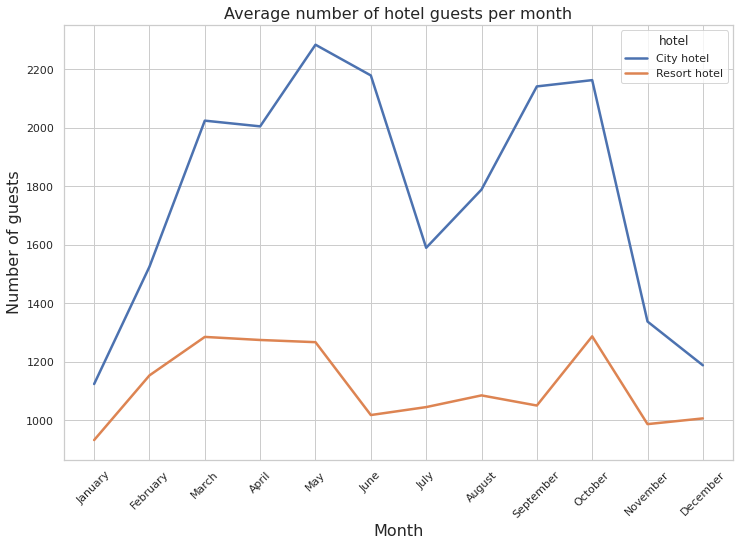

In [ ]:
# Create a DataFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly   = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({'month' :list(resort_guests_monthly.index),
                                  "hotel" :"Resort hotel",
                                  "guests":list(resort_guests_monthly.values)})

city_guest_data   = pd.DataFrame({"month":list(city_guests_monthly.index),
                                  "hotel":"City hotel",
                                  "guests": list(city_guests_monthly.values)})

full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index = True)


# Order by month
ordered_month = ["January","February","March","April","May","June",
                 "July","August","September","October","November","December"]

full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories = ordered_months, ordered = True) 

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July")|(full_guest_data["month"] == "August"), "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July")|(full_guest_data["month"] == "August")), "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

The City hotel has more guests during spring and autumn, when the prices are also highest.

In July and August there are less visitors, although prices are lower.

Guest numbers for the Resort hotel go down slighty from June to September, which is also when the prices are highest.

Both hotels have the fewest guests during the winter.

### **How long people stay at the hotels?**

In [ ]:
# Create a DataFrame with the relevant data
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_booking_res = list(rh["total_nights"].value_counts())
rel_booking_res = rh["total_nights"].value_counts()/sum(num_booking_res)*100 # Convert to percent

num_nights_city = list(ch["total_nights"].value_counts().index)
num_booking_city = list(ch["total_nights"].value_counts())
rel_booking_city = ch["total_nights"].value_counts() / sum(num_booking_city)*100 # Convert to percent

res_night = pd.DataFrame({"hotel":"Resort Hotel",
                          "num_nights":num_nights_res,
                          "rel_num_bookings":rel_booking_res})

city_night = pd.DataFrame({"hotel":"City Hotel",
                           "num_nights":num_nights_city,
                           "rel_num_bookings":rel_booking_city})

night_data = pd.concat([res_night, city_night], ignore_index = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



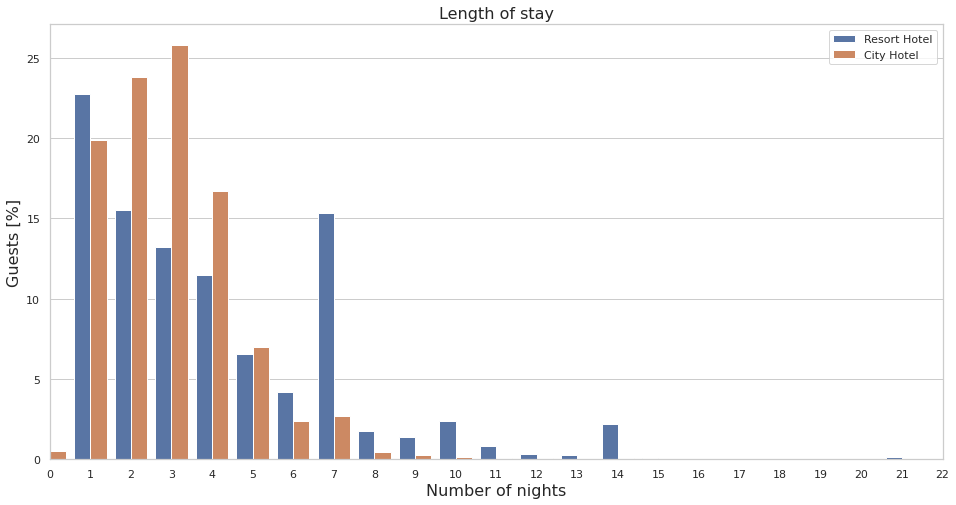

In [ ]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=night_data)
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [ ]:
avg_nights_res = sum(list((res_night["num_nights"] * (res_night["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((city_night["num_nights"] * (city_night["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {city_night['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_night['num_nights'].max()} at maximum.")

On average, guests of the City hotel stay 0.00 nights, and nan at maximum.
On average, guests of the Resort hotel stay 4.14 nights, and 69 at maximum.


For the city hotel there is a clear preference for 1-4 nights.
For the resort hotel, 1-4 nights are also often booked, but 7 nights also stand out as being very popular.

### **Bookings by market segment**

In [ ]:
# Total bookings per market segment (incl. canceled)
segments = full_data_cln["market_segment"].value_counts()

# Pie plot
fig = px.pie(segments,
             values = segments.values,
             names = segments.index,
             title = "Bookings per market segment",
             template = "seaborn")

fig.update_traces(rotation = 90, textinfo = "percent + label")
fig.show()

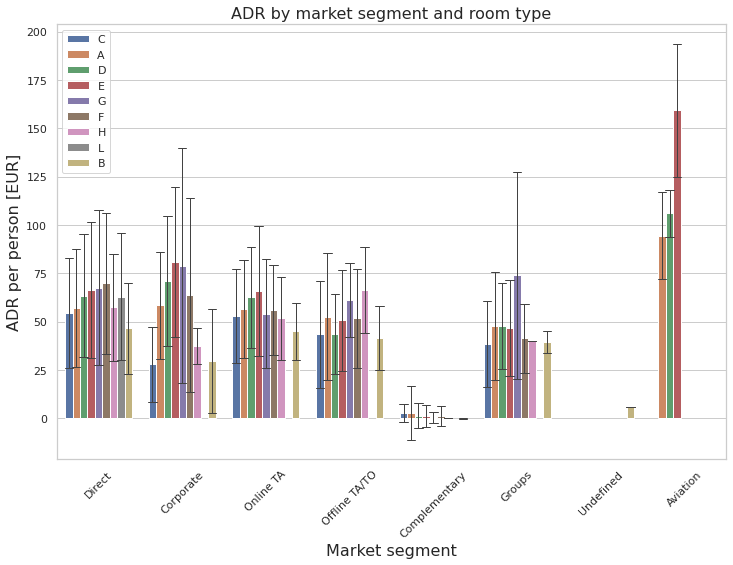

In [ ]:
# Price per night (ADR) and person based on booking and room
# show figure
plt.figure(figsize = (12,8))
sns.barplot(x = "market_segment",
            y = "adr_pp",
            hue = "reserved_room_type",
            data = full_data_cln,
            ci = "sd",
            errwidth = 1,
            capsize = 0.1)
plt.title("ADR by market segment and room type", fontsize = 16)
plt.xlabel("Market segment", fontsize = 16)
plt.xticks(rotation = 45)
plt.ylabel("ADR per person [EUR]", fontsize = 16)
plt.legend(loc = "upper left")
plt.show()

On average, groups get the best prices and Airlines pay approximately twice as much.

***What are possible resons for the high prices paid by Airlines?***


In [ ]:
# Summerize Relevant data
airline_data = full_data_cln.loc[full_data_cln["market_segment"] == "Aviation"][["is_canceled","adults","lead_time","adr_pp"]].describe()

Non_airline_data = full_data_cln.loc[full_data_cln["market_segment"] != "Aviation"][["is_canceled",
                                                                                     "adults",
                                                                                     "lead_time",
                                                                                     "adr_pp"]].describe() 

In [ ]:
airline_data.head()

,is_canceled,adults,lead_time,adr_pp
count,235.000000,235.000000,235.00000,235.000000
mean,0.221277,1.012766,4.47234,100.270979
std,0.415992,0.112503,4.61629,20.376689
min,0.000000,1.000000,0.00000,0.000000
25%,0.000000,1.000000,1.00000,95.000000


In [ ]:
Non_airline_data.head()

,is_canceled,adults,lead_time,adr_pp
count,118975.000000,118975.000000,118975.000000,118975.000000
mean,0.371061,1.860878,104.306031,55.036835
std,0.483091,0.574499,106.888885,29.017596
min,0.000000,0.000000,0.000000,-3.190000
25%,0.000000,2.000000,18.000000,37.440000


* ***Lead time for bookings from Aviation is very short: Mean 4 days*** vs. 104 days for other bookings.
* Airlines NEED a place for their crews to stay.
* ***Airline personel usually gets one room per person*** - more total rooms required compared to families.

### **How many bookings were canceled?**

In [ ]:
# absolute cancelations
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent
rel_cancel = total_cancelations / full_data_cln.shape[0]*100
rh_rel_cancel = rh_cancelations/ full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0]*100
ch_rel_cancel = ch_cancelations/ full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0]*100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


### **Which month have the highest number of cancelations?**

In [ ]:
full_data_cln.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_pp
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.0


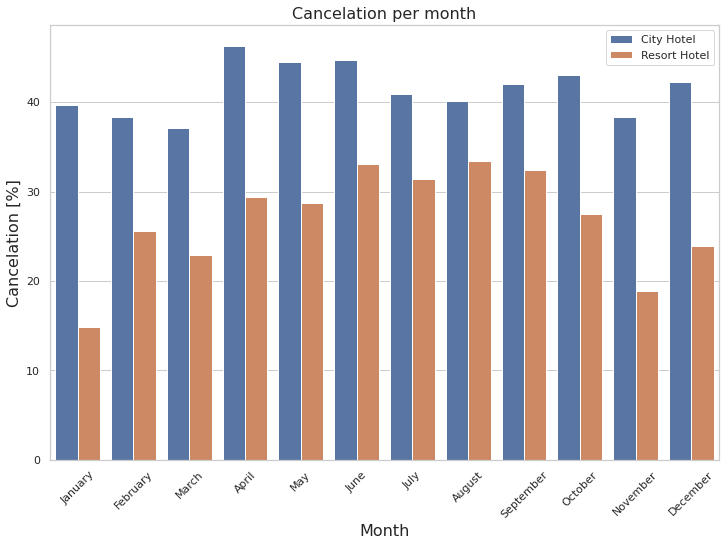

In [ ]:
# Create a DataFrame with the relevant data
res_book_per_month   = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month   = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel":"Resort Hotel",
                                "Month":list(res_book_per_month.index),
                                "Bookings":list(res_book_per_month.values),
                                "Cancelations":list(res_cancel_per_month.values)})
city_cancel_data = pd.DataFrame({"Hotel":"City Hotel",
                            "Month":list(cty_book_per_month.index),
                            "Bookings":list(cty_book_per_month.values),
                            "Cancelations":list(cty_cancel_per_month.values)})
full_cancel_data = pd.concat([res_cancel_data,city_cancel_data], ignore_index = True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"]/full_cancel_data["Bookings"]*100

# Order by month:
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories = ordered_months, ordered = True)

# Show figure
plt.figure(figsize = (12,8))
sns.barplot(x = "Month", y = "cancel_percent", hue = "Hotel",
            hue_order = ["City Hotel","Resort Hotel"], data = full_cancel_data)
plt.title("Cancelation per month", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.ylabel("Cancelation [%]", fontsize = 16)
plt.xticks(rotation = 45)
plt.legend(loc = "upper right")
plt.show()

For the City hotel the relative number of cancelations is **around 40 % throughout the year.**
For the Resort hotel it is highest in **the summer and lowest during the winter.**

## **2.Predict Cancelation**

Which numerical features are most important?

In [ ]:
cancel_corr = df.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending = False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

From this list it is apparent that lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations are the 5 most important numerical features.

However, to predict wheater or not a booking will be canceled, the number of booking changes is a possible source of leakage, because this information can change over time.

I will also not include days_in_waiting_list and arrival_date_year.

The most important feature to exclude is the "reservation_status":

In [ ]:
df.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

### **Comparing different base models:**

In [ ]:
# Manually choose columns to include
# Some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country, days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Seperate features and predicted value
features = num_features + cat_features
x = df.drop(["is_canceled"], axis = 1)[features]
y = df["is_canceled"]

# Preprocessing numerical feats
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing

num_transformer = SimpleImputer(strategy = "constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "constant", fill_value = "Unknown")),
    ("onehot", OneHotEncoder(handle_unknown = "ignore"))
])
# Bundle preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(transformers = [("num", num_transformer, num_features),
                                                 ("cat", cat_transformer, cat_features)])


In [ ]:
# Define models to test
base_models = [("DT_models", DecisionTreeClassifier(random_state = 42)),
               ("RF_models", RandomForestClassifier(random_state = 42)),
               ("LR_models", LogisticRegression(random_state = 42, n_jobs = 1)),
               ("XGB_model", XGBClassifier(random_state = 42, n_jobs = 1))]

# split data into 'kfold' parts for cross validation
# use shuffle to ensure random distribution of data:

kfolds = 4 
split = KFold(n_splits = kfolds, shuffle = True, random_state = 42)

# Preprocessing, fitting, making prediction and scoring for every model
for name, model in base_models:
  # Pack preprocessing of data and the model in a pineline
  model_steps = Pipeline(steps = [("preprocessor", preprocessor),
                                  ("model",model)])
  # Get across validation score for each model:
  cv_results = cross_val_score(model_steps,
                               x,y,
                               cv = split,
                               scoring = "accuracy",
                               n_jobs = 1)
  # Output
  min_score = round(min(cv_results),4)
  max_score = round(max(cv_results),4)
  mean_score = round(np.mean(cv_results),4)
  std_dev = round(np.std(cv_results),4)
  print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    
    #pipeline.fit(X_train, y_train)
    #preds = pipeline.predict(X_valid)
    #score = accuracy_score(y_valid, preds)
    #print(f"{name} accuracy_score: {round(score, 4)}")


DT_models cross validation accuarcy score: 0.8246 +/- 0.0016 (std) min: 0.8221, max: 0.8263
RF_models cross validation accuarcy score: 0.8664 +/- 0.0012 (std) min: 0.8646, max: 0.8676


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

LR_models cross validation accuarcy score: 0.7937 +/- 0.0012 (std) min: 0.792, max: 0.7953
XGB_model cross validation accuarcy score: 0.8165 +/- 0.0016 (std) min: 0.8139, max: 0.8181


In [ ]:
#Enhance RF model with the best parameters I found:
rf_model_enh = RandomForestClassifier(n_estimators = 160,
                                      max_features = 0.4,
                                      min_samples_split = 2,
                                      n_jobs = 1,
                                      random_state = 0)

split = KFold(n_splits = kfolds, shuffle = True, random_state = 42)
model_pipe = Pipeline(steps = [("preprocessor", preprocessor),
                               ("model", rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                             x,y,
                             cv = split, 
                             scoring = "accuracy",
                             n_jobs = 1)

# Output 
min_score  = round(min(cv_results),4)
max_score  = round(min(cv_results),4)
mean_score = round(np.mean(cv_results),4)
std_dev    = round(np.std(cv_results),4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")


Enhanced RF model cross validation accuarcy score: 0.8681 +/- 0.0006 (std) min: 0.8673, max: 0.8673


# **3. Evaluate Feature Importance**

In [ ]:
# Fit model(pipeline) so values can be assessed:
model_pipe.fit(x,y)

# Names of all (encoded) features are needed
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"].get_feature_names(input_features = cat_features))

# Add num_features for full list
# Order must be as in definition of X, where num_features are first:
feat_imp_list = num_features + onehot_columns

# Show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps["model"], 
    feature_names = feat_imp_list)
feat_imp_df.head(5)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033


Looking at the three most important features:
* lead_time
* deposit_type
* adr

#### **Lead_time**

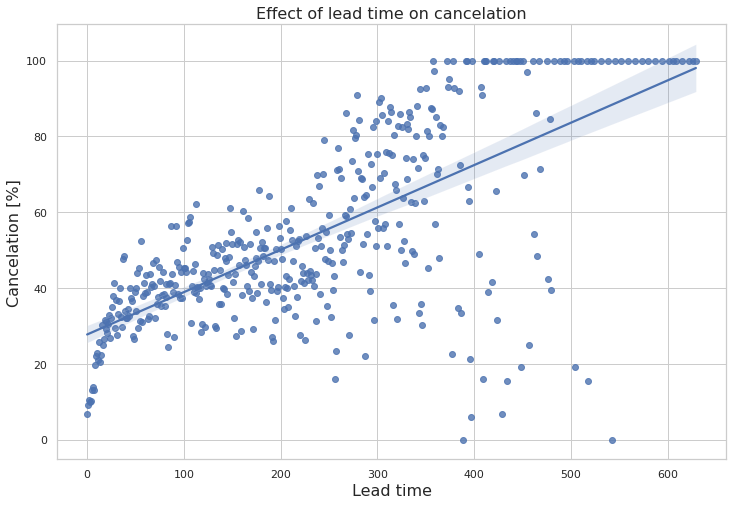

In [ ]:
# Group data for lead_time
lead_cancel_data = full_data_cln.groupby("lead_time")["is_canceled"].describe()
# Use only lead_times with more than 10 bookings for graphs:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

# Show figure
plt.figure(figsize = (12,8))
sns.regplot(x = lead_cancel_data_10.index, y = lead_cancel_data_10["mean"].values*100)
plt.title("Effect of lead time on cancelation", fontsize = 16)
plt.xlabel("Lead time", fontsize = 16)
plt.ylabel("Cancelation [%]", fontsize = 16)
# plt.xlim(0,365)
plt.show()

Bookings made ***a few days*** before the arrival date are ***rarely canceled***, whereas ***bookings made over one year in advance are canceled very often***

#### **Deposit Type**

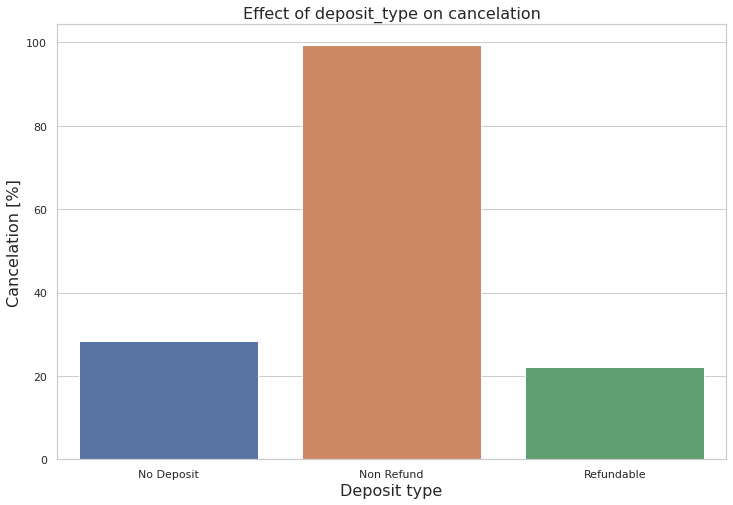

In [ ]:
# Group data for deposit_type:
deposit_cancel_data = full_data_cln.groupby("deposit_type")["is_canceled"].describe()

# Show figure
plt.figure(figsize = (12,8))
sns.barplot(x = deposit_cancel_data.index, y = deposit_cancel_data["mean"]*100)
plt.title("Effect of deposit_type on cancelation", fontsize = 16)
plt.xlabel("Deposit type", fontsize = 16)
plt.ylabel("Cancelation [%]", fontsize = 16)
plt.show()

As Susmit Vengurlekar already pointed out in the Discussion section of the dataset, the deposit_type 'Non Refund' and the 'is_canceled' column are correlated in a counter-intuitive way.

Over 99 % of people who paid the entire amount upfront canceled. This raises the question if there is something wrong with the data (or the description).

What else stands out for Non Refund deposits?

Here is a table of all mean values of the data, grouped by deposit type:

In [ ]:
deposit_mean_data = full_data_cln.groupby("deposit_type").mean()
deposit_mean_data

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,adr_pp
deposit_type,,,,,,,,,,,,,,,,,,,,,
No Deposit,0.284020,88.841951,2016.173950,27.133208,15.815223,0.969615,2.555633,1.865806,0.118599,0.009085,0.035295,0.042044,0.154938,0.247030,78.745503,11.175874,1.518040,103.685436,0.071184,0.651726,55.231806
Non Refund,0.993624,212.908891,2016.031466,27.448619,15.595462,0.621718,2.091109,1.811407,0.000617,0.000000,0.004387,0.411462,0.010626,0.012477,47.480016,6.215809,7.992253,89.964017,0.000069,0.001782,54.520286
Refundable,0.222222,152.098765,2016.141975,20.932099,23.456790,0.975309,2.851852,1.907407,0.030864,0.000000,0.024691,0.000000,0.018519,0.592593,56.185185,133.666667,9.586420,76.209753,0.123457,0.141975,41.444239


Comparing the mean values for Non refund to No Deposit shows the following:

* Non Refund deposits are characterized by > 2x longer lead_time
* is_repeated_guest is ~ 1/10th
* previous_cancellations is 10x higher
* previous_bookings_not_canceled is 1/15th
* required_car_parking_spaces is almost zero
* special requests are very rare

Based on these findings it seems that especially people who have not previosly visited one of the hotels book, pay and cancel repeatedly... this is strange!

To adress this issue, I will make a model without this feature below.

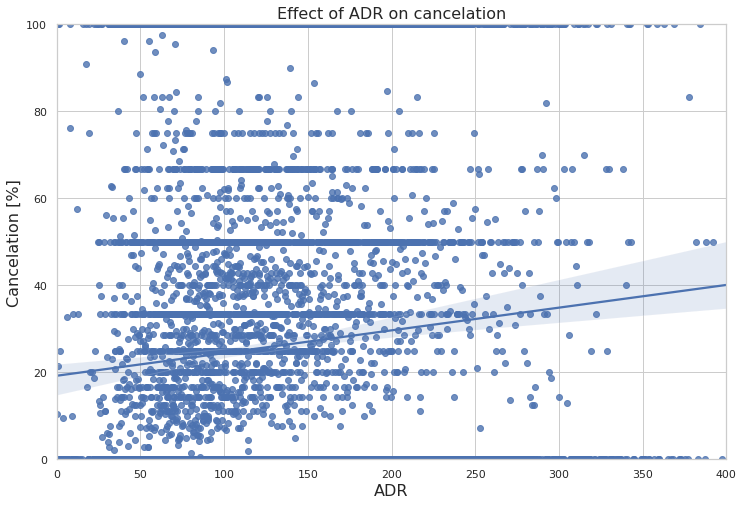

In [ ]:
# Group data for adr:
adr_cancel_data = full_data_cln.groupby("adr")["is_canceled"].describe()
# Show figure
plt.figure(figsize = (12,8))
sns.regplot(x = adr_cancel_data.index , y = adr_cancel_data["mean"].values*100)
plt.title("Effect of ADR on cancelation", fontsize = 16)
plt.xlabel("ADR", fontsize = 16)
plt.ylabel("Cancelation [%]", fontsize = 16)
plt.xlim(0,400)
plt.ylim(0,100)
plt.show()

#### **RF model without deposit type:**

In [ ]:
cat_features_non_dep = ["hotel","arrival_date_month","meal","market_segment",
                        "distribution_channel","reserved_room_type","customer_type"]

features_non_dep = num_features + cat_features_non_dep
x_non_dep = df.drop(["is_canceled"], axis = 1)[features_non_dep]

# Bundle preprocessing for numerical and categorical features
preprocessor_non_dep = ColumnTransformer(transformers = [("num", num_transformer, num_features),
                                                         ("cat", cat_transformer, cat_features_non_dep)])

# Define Dataset
x_non_dep = df.drop(["is_canceled"], axis = 1 )[features_non_dep]

# Define model
rf_model_non_dep = RandomForestClassifier(random_state = 42) # basic model for this purpose

kfolds = 4
split = KFold(n_splits = kfolds, shuffle = True, random_state = 42)

model_pipe = Pipeline(steps = [("preprocessor", preprocessor_non_dep),
                               ("model",rf_model_non_dep)])

cv_results = cross_val_score(model_pipe, x_non_dep, y
                             , cv= split,
                             scoring = "accuracy",
                             n_jobs = 1)
# Output
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"RF model without deposit_type feature cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

RF model without deposit_type feature cross validation accuarcy score: 0.8653 +/- 0.0013 (std) min: 0.8631, max: 0.8663


In [ ]:
# Feat importance of original Model
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459


In [ ]:
# Check feature importance of new model
# fit model(pipeline) so value can be accessed:
model_pipe.fit(x_non_dep, y)

# Names of all (encoded) features are needed
# Get names of columns from One Hot Encoding:

onehot_columns = list(model_pipe.named_steps["preprocessor"].
                     named_transformers_["cat"].
                     named_steps["onehot"].
                     get_feature_names(input_features = cat_features_non_dep))

# Add num_features for full list
# Order must be as in defintion of X, where num_features are first

feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df_non_dep = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
#---------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
# feat importance of new model:
feat_imp_df_non_dep.head(10)

,feature,weight,std
0,lead_time,0.175189,0.019580
1,adr,0.111566,0.008185
2,total_of_special_requests,0.078749,0.013435
3,arrival_date_day_of_month,0.076958,0.003056
4,arrival_date_week_number,0.060699,0.004069
5,agent,0.054862,0.009409
6,stays_in_week_nights,0.049275,0.004647
7,previous_cancellations,0.047592,0.016409
8,stays_in_weekend_nights,0.031298,0.002617
9,customer_type_Transient,0.028016,0.018087


The new accuracy score of 0.8653 is almost identical to the one obtained with the deposit_type included (0.8664),
which placed significant wheight on this feature.
The new model compensated this by placing increased weight on lead_time, adr, total_of_special_requests and others.